<a href="https://colab.research.google.com/github/falawar7/AAI614_ELAWAR/blob/main/Week7/FE_Notebook7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AAI614: Data Science & its Applications

*Notebook 7.1: Introducing Dask*


Source: NVIDIA

# Dask

Dask is not faster than pandas for a single file or for small size data.  It excels for multiple data as it uses lazy computaion. In this lab, we will learn how to use Dask to speed up computation under the correct conditions.

First, let's get these libraries loaded.

In [ ]:
!git clone https://github.com/harmanani/AAI614.git /content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/data

Cloning into '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/data'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 328 (delta 141), reused 158 (delta 101), pack-reused 118 (from 1)
Receiving objects: 100% (328/328), 299.47 MiB | 9.93 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Updating files: 100% (226/226), done.


In [ ]:
/content/AAI614/Week 7/data

In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 3.5 MB/s eta 0:00:00


In [ ]:
!pip install dask

import dask.dataframe as dd
import glob
import pandas as pd
import time
import urllib
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

## Using Dask versus Pandas

Neither pandas or cuDF can read in multiple CSV files directly with [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). In order to read multiple files into a DataFrame, we would need to loop through each file and append them together.

To see this, let's pull a couple more files from the [Water Level Website](https://tidesandcurrents.noaa.gov/stations.html?type=Water+Levels). This time, we will request a CSV and save it with the [urllib.request](https://docs.python.org/3/library/urllib.request.html).

We should now have a few `.csv` files in the `data` folder. When referencing these files, we could type out the paths of each of these files individually, but instead, we will use the [glob](https://docs.python.org/3/library/glob.html) library to programmatically do this for us. We can use `*` as a wild card to filter files that match our pattern specified like so:

In [ ]:
file_paths = glob.glob('/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/*.csv')
file_paths = [file for file in file_paths if file != 'data/numbers.csv']
file_paths

['/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00024534.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00027876.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00030220.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00010957.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00014209.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00024586.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00015553.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00012124.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00010140.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00013043.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00012675.csv',
 '/content

Each path starts with `data`, ends with `.csv`, and the `*` indicates to pick up anything in between. Let's set up a for loop to see how long it takes to read all of these files. Run the block **twice** to see how much faster cuDF is after it has been initialized.

In [ ]:
usecols = [0, 1, 2, 4, 5]  # Column names are different when pulling csv directly


def read_all(library, file_paths):
    df_list = []
    for file in file_paths:
        df = library.read_csv(
            file, index_col=None, header=None, usecols=usecols, skiprows=1
        )
        df_list.append(df)
    return library.concat(df_list, axis=0, ignore_index=True)



df_cpu = read_all(pd, file_paths)

In [ ]:
df_cpu

,0,1,2,4,5
0,USC00024534,31.8352,-110.355,2010-03-02,HPCP
1,USC00024534,31.8352,-110.355,2010-03-03,HPCP
2,USC00024534,31.8352,-110.355,2010-03-04,HPCP
3,USC00024534,31.8352,-110.355,2010-03-05,HPCP
4,USC00024534,31.8352,-110.355,2010-03-06,HPCP
...,...,...,...,...,...
1013567,USC00015397,32.0347,-85.474,2021-01-28,HPCP
1013568,USC00015397,32.0347,-85.474,2021-01-29,HPCP
1013569,USC00015397,32.0347,-85.474,2021-01-30,HPCP
1013570,USC00015397,32.0347,-85.474,2021-01-31,HPCP


Since Dask is made to be parallel, we do not need a for loop. It can read multiple files natively.

The below code shows how to read data in parallel. This only sets up the process to read the files. we need to force Dask to *compute*

In [ ]:
ddf_cpu = dd.read_csv(file_paths, usecols=usecols, header=0, skipinitialspace=True)

ddf_cpu.compute()

,STATION,LATITUDE,LONGITUDE,DATE,ELEMENT
0,USC00024534,31.8352,-110.355,2010-03-02,HPCP
1,USC00024534,31.8352,-110.355,2010-03-03,HPCP
2,USC00024534,31.8352,-110.355,2010-03-04,HPCP
3,USC00024534,31.8352,-110.355,2010-03-05,HPCP
4,USC00024534,31.8352,-110.355,2010-03-06,HPCP
...,...,...,...,...,...
22287,USC00015397,32.0347,-85.474,2021-01-28,HPCP
22288,USC00015397,32.0347,-85.474,2021-01-29,HPCP
22289,USC00015397,32.0347,-85.474,2021-01-30,HPCP
22290,USC00015397,32.0347,-85.474,2021-01-31,HPCP


Let's sample our data to confirm it had been read correctly. This time, we will only be working with the first three columns of data.

In [ ]:
%%time
ddf_cpu.head()

How can Dask do this faster than regular pandas or cuDF? Under the hood, Dask is building a system of operations called a DAG. We can view this DAG with the [visualize](https://docs.dask.org/en/latest/graphviz.html) method.

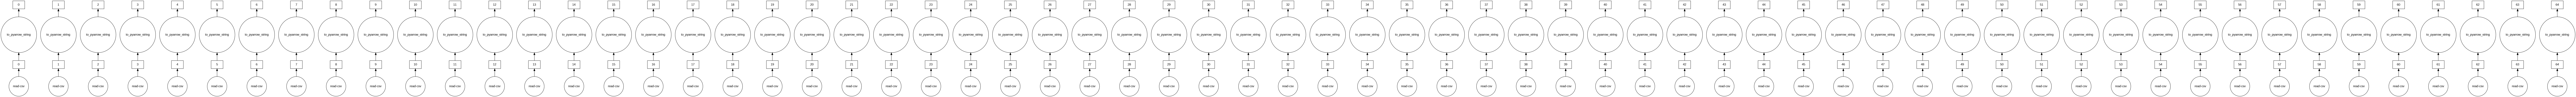

In [ ]:
ddf_cpu.visualize()

In [ ]:
file_paths = glob.glob('/content/AAI614/Week 2/nyc_taxi/*.csv')
file_paths = [file for file in file_paths if file != 'data/numbers.csv']
file_paths

['/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-07ak.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-01bf.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-01au.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-01aa.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-01ak.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-01ao.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-01aw.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-07aq.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-07at.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-01ai.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-01ab.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-01an.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-01at.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-01aq.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-07ap.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-01bc.csv',
 '/content/AAI614/Week 2/nyc_taxi/nyc_taxi_2019-07ay.csv

In [ ]:
usecols = [0, 1, 2, 4, 5]  # Column names are different when pulling csv directly


def read_all(library, file_paths):
    df_list = []
    for file in file_paths:
        df = library.read_csv(
            file, index_col=None, header=None, usecols=usecols, skiprows=1
        )
        df_list.append(df)
    return library.concat(df_list, axis=0, ignore_index=True)



df_cpu = read_all(pd, file_paths)

In [ ]:
df_cpu

,0,1,2,4,5
0,2.0,2019-07-13 05:59:58,2019-07-13 06:07:47,2.67,1.0
1,2.0,2019-07-13 05:09:01,2019-07-13 05:17:12,3.29,1.0
2,1.0,2019-07-13 05:21:32,2019-07-13 05:31:14,3.30,1.0
3,1.0,2019-07-13 05:38:20,2019-07-13 05:48:12,3.20,1.0
4,1.0,2019-07-13 05:55:29,2019-07-13 05:59:10,0.60,1.0
...,...,...,...,...,...
13978205,2.0,2019-07-18 13:56:49,2019-07-18 14:20:47,1.70,1.0
13978206,1.0,2019-07-18 13:44:23,2019-07-18 13:52:09,1.50,1.0
13978207,1.0,2019-07-18 13:58:08,2019-07-18 13:59:54,0.10,1.0
13978208,2.0,2019-07-18 13:09:09,2019-07-18 14:20:14,16.85,2.0


In [ ]:
%%time
ddf_cpu.head()

CPU times: user 41.6 ms, sys: 1.76 ms, total: 43.4 ms
Wall time: 43.8 ms


,STATION,LATITUDE,LONGITUDE,DATE,ELEMENT
0,USC00024534,31.8352,-110.355,2010-03-02,HPCP
1,USC00024534,31.8352,-110.355,2010-03-03,HPCP
2,USC00024534,31.8352,-110.355,2010-03-04,HPCP
3,USC00024534,31.8352,-110.355,2010-03-05,HPCP
4,USC00024534,31.8352,-110.355,2010-03-06,HPCP


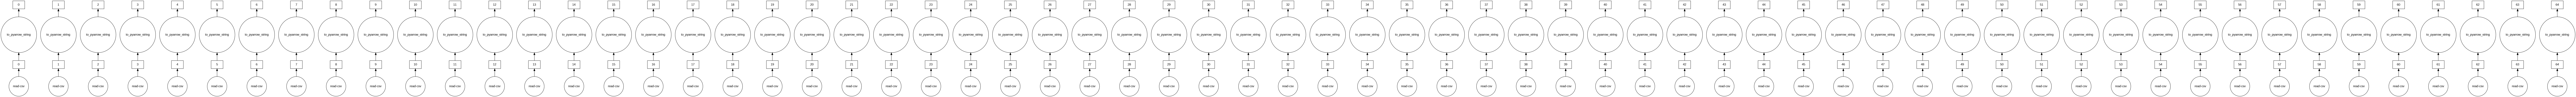

In [ ]:
ddf_cpu.visualize()